In [25]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [27]:
IMAGE_SIZE=224
BATCH_SIZE=16
CHANNELS=3
EPOCHS = 50

In [29]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [31]:
ds=tf.keras.preprocessing.image_dataset_from_directory(
"C:/Users/narth/Downloads/Banana Disease Recognition Dataset/Banana Dataset Cleaned",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    )

Found 611 files belonging to 7 classes.


In [33]:
class_names= ds.class_names
class_names

['Banana Black Sigatoka Disease',
 'Banana Bract Mosaic Virus Disease',
 'Banana Healthy Leaf',
 'Banana Insect Pest Disease',
 'Banana Moko Disease',
 'Banana Panama Disease',
 'Banana Yellow Sigatoka Disease']

In [35]:
for image_batch, labels_batch in ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 224, 224, 3)
[2 2 6 6 2 6 2 1 4 0 2 2 4 1 3 3]


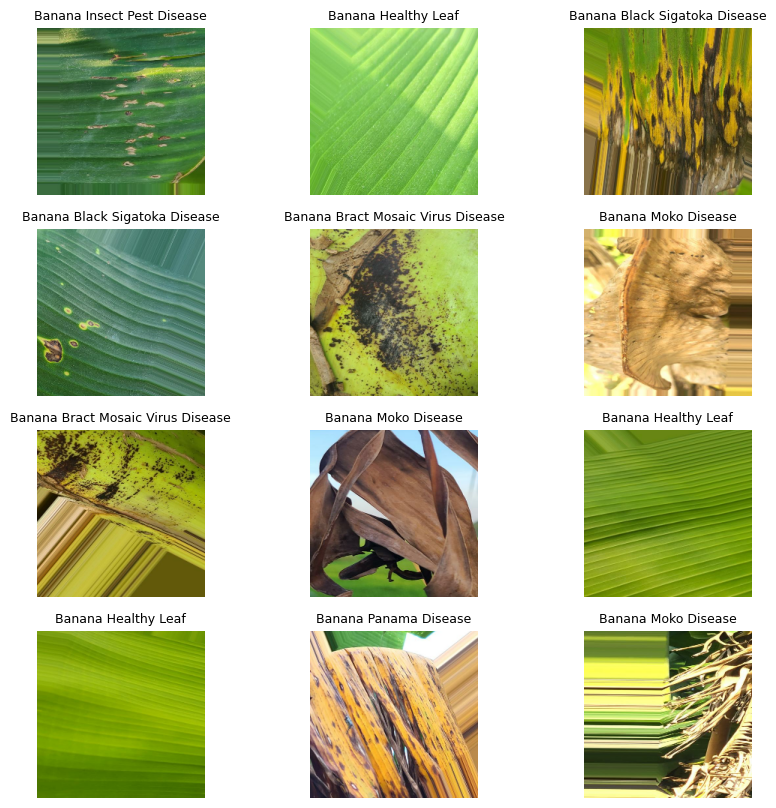

In [37]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]],fontsize=9,wrap=True)
        plt.axis("off")

In [38]:
len(ds)

39

In [41]:
train_size = 0.8
len(ds)*train_size

31.200000000000003

In [43]:
train_dataset=ds.take(31)
len(train_dataset)

31

In [45]:
test_dataset=ds.skip(31)
len(test_dataset)

8

In [47]:
val_size=0.2
len(ds)*val_size

7.800000000000001

In [49]:
val_ds = test_dataset.take(7)
len(val_ds)

7

In [51]:
def get_dataset_partitions_tf(dss, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(dss)
    
    if shuffle:
        dss = dss.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = dss.take(train_size)    
    val_ds = dss.skip(train_size).take(val_size)
    test_ds = dss.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [53]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

In [55]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [59]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [61]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [63]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),             # Simulate natural flipping
    layers.RandomRotation(0.05),                
    layers.RandomZoom(0.1),                     
    layers.RandomContrast(0.1),                  
])


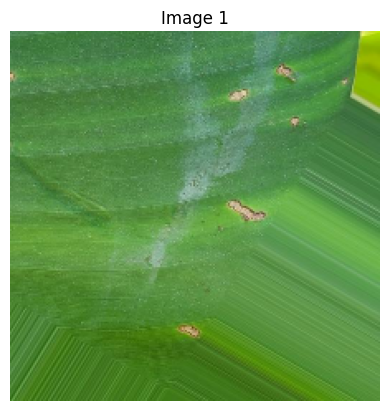

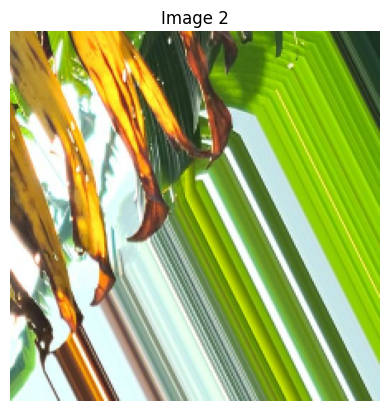

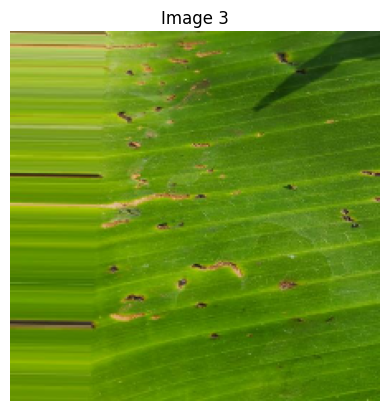

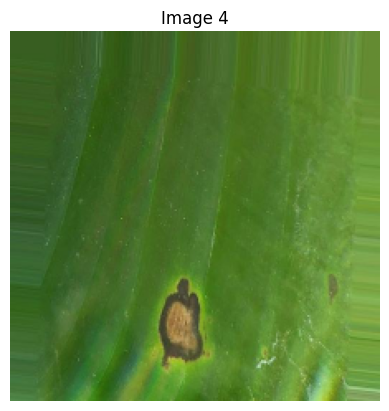

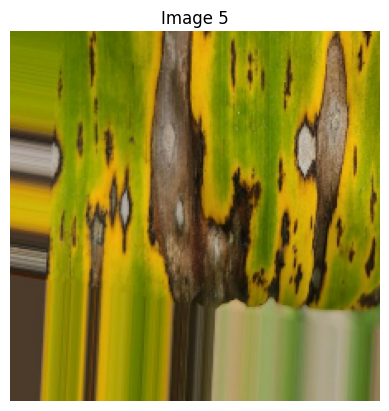

In [65]:
import matplotlib.pyplot as plt

for images, _ in train_ds.take(1):
    for i in range(5):
        img = images[i].numpy() / 255.0  # Normalize 
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {i+1}")
        plt.show()

In [67]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [69]:
from tensorflow.keras import Input, layers, models

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Exclude BATCH_SIZE here
n_classes = 14

model_cnn = models.Sequential([
    Input(shape=input_shape),  
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [71]:
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)       

In [73]:
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)


In [75]:
history = model_cnn.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50, 
)

Epoch 1/50
31/31 [==============================] - 8s 190ms/step - loss: 2.1310 - accuracy: 0.1875 - val_loss: 1.9827 - val_accuracy: 0.3958
Epoch 2/50
31/31 [==============================] - 5s 161ms/step - loss: 1.8209 - accuracy: 0.2903 - val_loss: 1.5911 - val_accuracy: 0.3958
Epoch 3/50
31/31 [==============================] - 5s 154ms/step - loss: 1.5561 - accuracy: 0.3589 - val_loss: 1.2978 - val_accuracy: 0.5625
Epoch 4/50
31/31 [==============================] - 5s 158ms/step - loss: 1.3205 - accuracy: 0.4879 - val_loss: 1.4245 - val_accuracy: 0.5208
Epoch 5/50
31/31 [==============================] - 5s 158ms/step - loss: 1.1594 - accuracy: 0.5383 - val_loss: 1.1467 - val_accuracy: 0.5208
Epoch 6/50
31/31 [==============================] - 5s 158ms/step - loss: 1.0705 - accuracy: 0.5625 - val_loss: 0.9684 - val_accuracy: 0.5625
Epoch 7/50
31/31 [==============================] - 5s 159ms/step - loss: 0.9847 - accuracy: 0.6089 - val_loss: 0.8828 - val_accuracy: 0.6042
Epoch 

In [77]:
scores = model_cnn.evaluate(test_ds)


5/5 [==============================] - 1s 88ms/step - loss: 0.6447 - accuracy: 0.8625


In [79]:
scores

[0.6446579098701477, 0.862500011920929]

In [81]:
history

In [83]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 31}

In [85]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [87]:
type(history.history['loss'])

list

In [89]:
len(history.history['loss'])

50

In [91]:
history.history['loss'][:5]

[2.130981206893921,
 1.820855736732483,
 1.5561143159866333,
 1.3204615116119385,
 1.159438133239746]

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

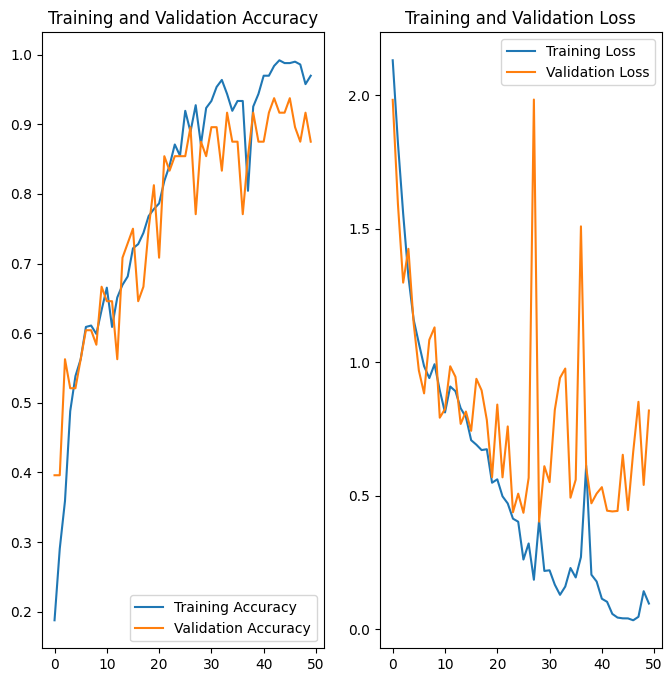

In [95]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [97]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Unbatch the test dataset and collect images and labels
y_true = []
y_pred = []

for images, labels in test_ds.unbatch():
    img_array = tf.expand_dims(images, axis=0)  # Add batch dimension
    predictions = model_cnn.predict(img_array, verbose=0)
    predicted_label = tf.argmax(predictions[0]).numpy()

    y_true.append(labels.numpy())
    y_pred.append(predicted_label)

first image to predict
actual label: Banana Bract Mosaic Virus Disease
1/1 [==============================] - 0s 73ms/step
predicted label: Banana Bract Mosaic Virus Disease


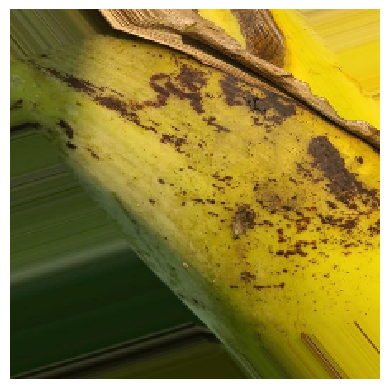

In [98]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model_cnn.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.imshow(first_image, interpolation='nearest')  # or 'bilinear'
plt.axis("off")
plt.show()


In [99]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


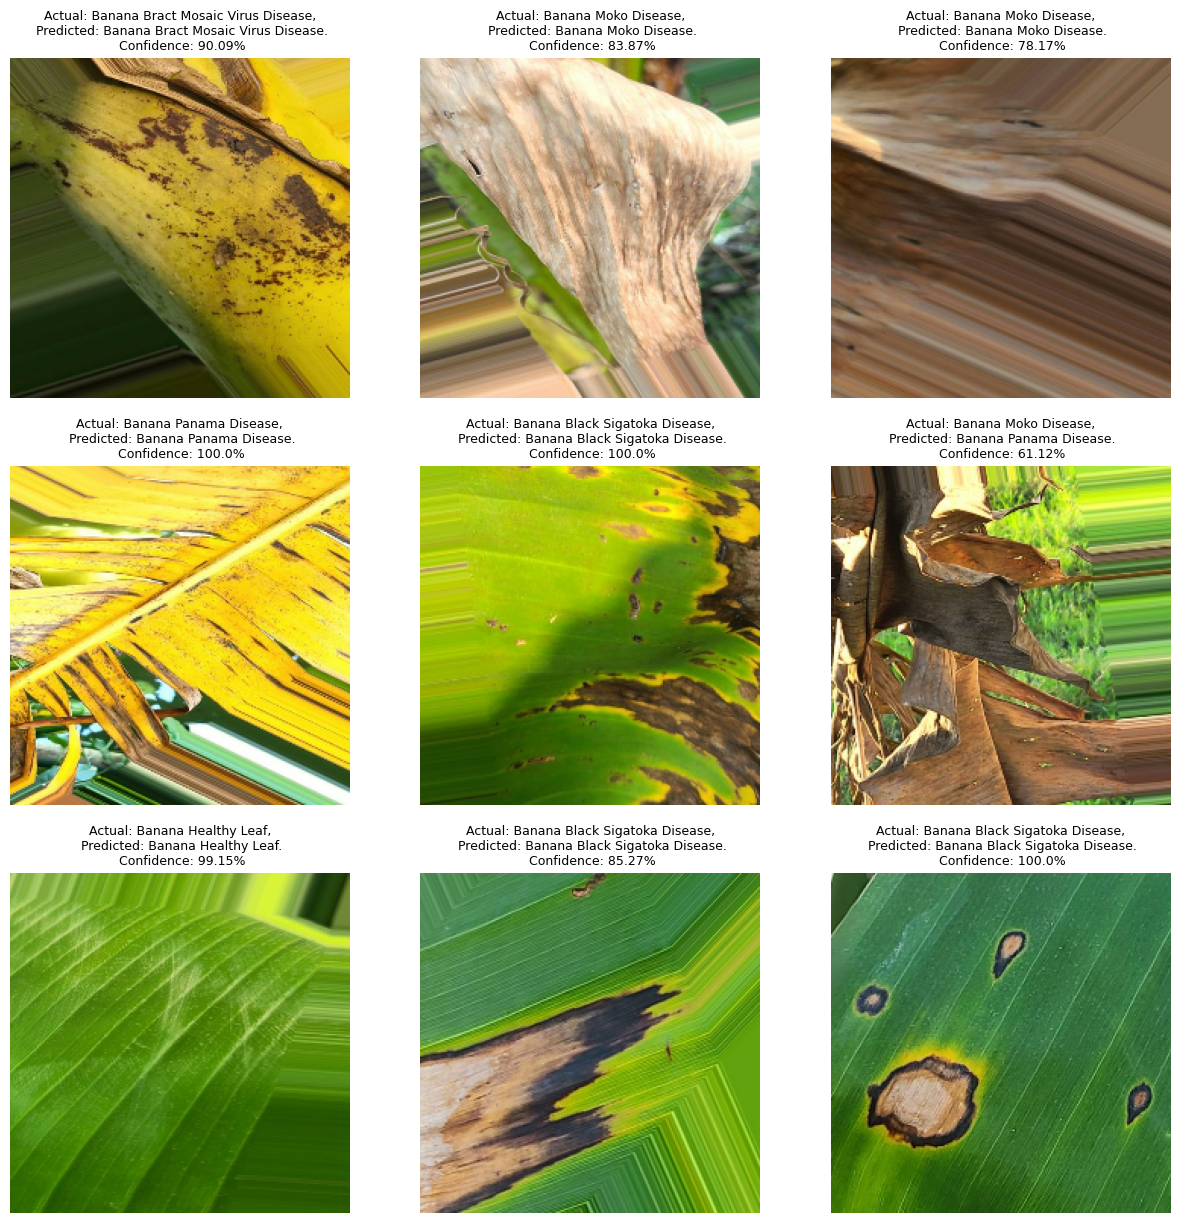

In [100]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_cnn, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%",fontsize=9)
        
        plt.axis("off")

1/1 [==============================] - 0s 99ms/step


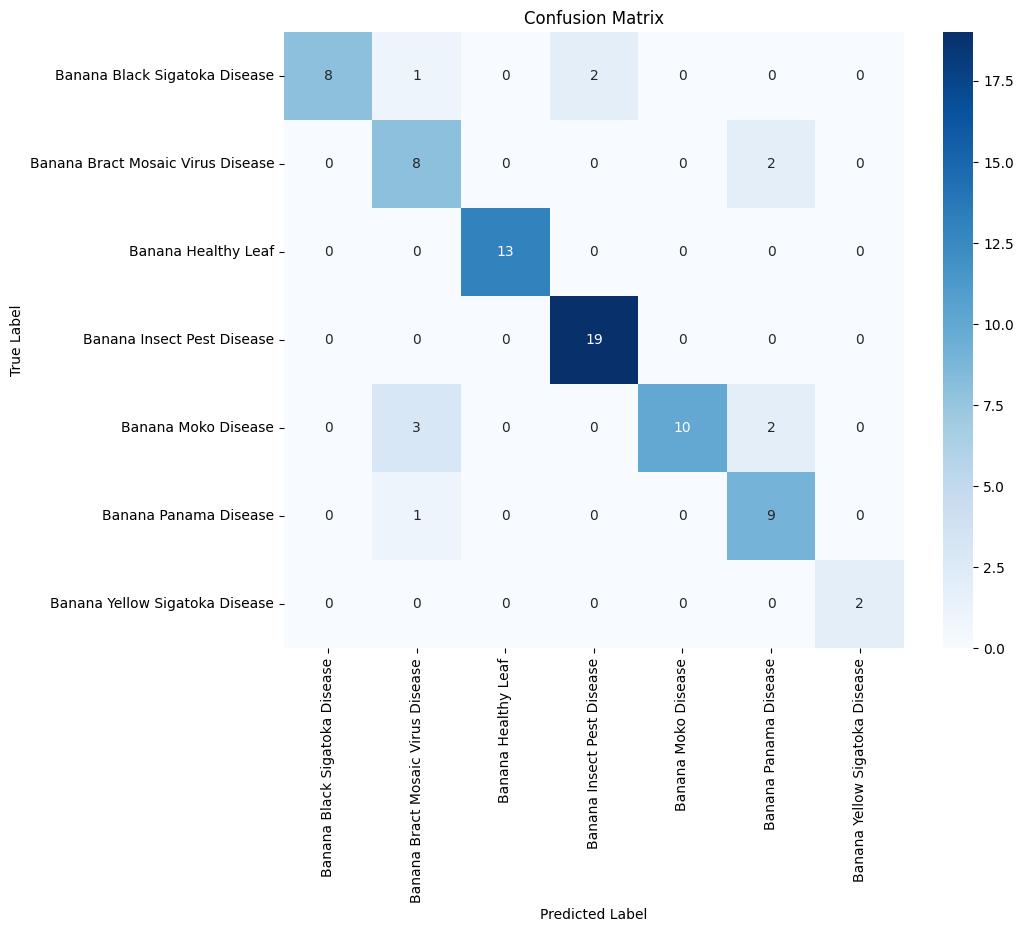

Accuracy: 0.86
Classification Report:
                                   precision    recall  f1-score   support

    Banana Black Sigatoka Disease       1.00      0.73      0.84        11
Banana Bract Mosaic Virus Disease       0.62      0.80      0.70        10
              Banana Healthy Leaf       1.00      1.00      1.00        13
       Banana Insect Pest Disease       0.90      1.00      0.95        19
              Banana Moko Disease       1.00      0.67      0.80        15
            Banana Panama Disease       0.69      0.90      0.78        10
   Banana Yellow Sigatoka Disease       1.00      1.00      1.00         2

                         accuracy                           0.86        80
                        macro avg       0.89      0.87      0.87        80
                     weighted avg       0.89      0.86      0.86        80



In [105]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_cnn.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)


# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2f}")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [107]:
import os

# Create the folder if it doesn't exist
os.makedirs("../models", exist_ok=True)

model_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1
model_cnn.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [108]:
model_cnn.save("bananaplant_tf215.keras")  


In [ ]:
#INCEPTIONV3 MODEL

Found 3125 files belonging to 14 classes.
Found 611 files belonging to 14 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 14)                28686     
                                                                 
Total params: 21831470 (83.28 MB)
Trainable params: 28686 (112.05 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch 1/10
98/98 [==============================] - 113s 1s/step - loss: 1.0746 - accuracy: 0.6906 - val_loss: 0.5612 - val

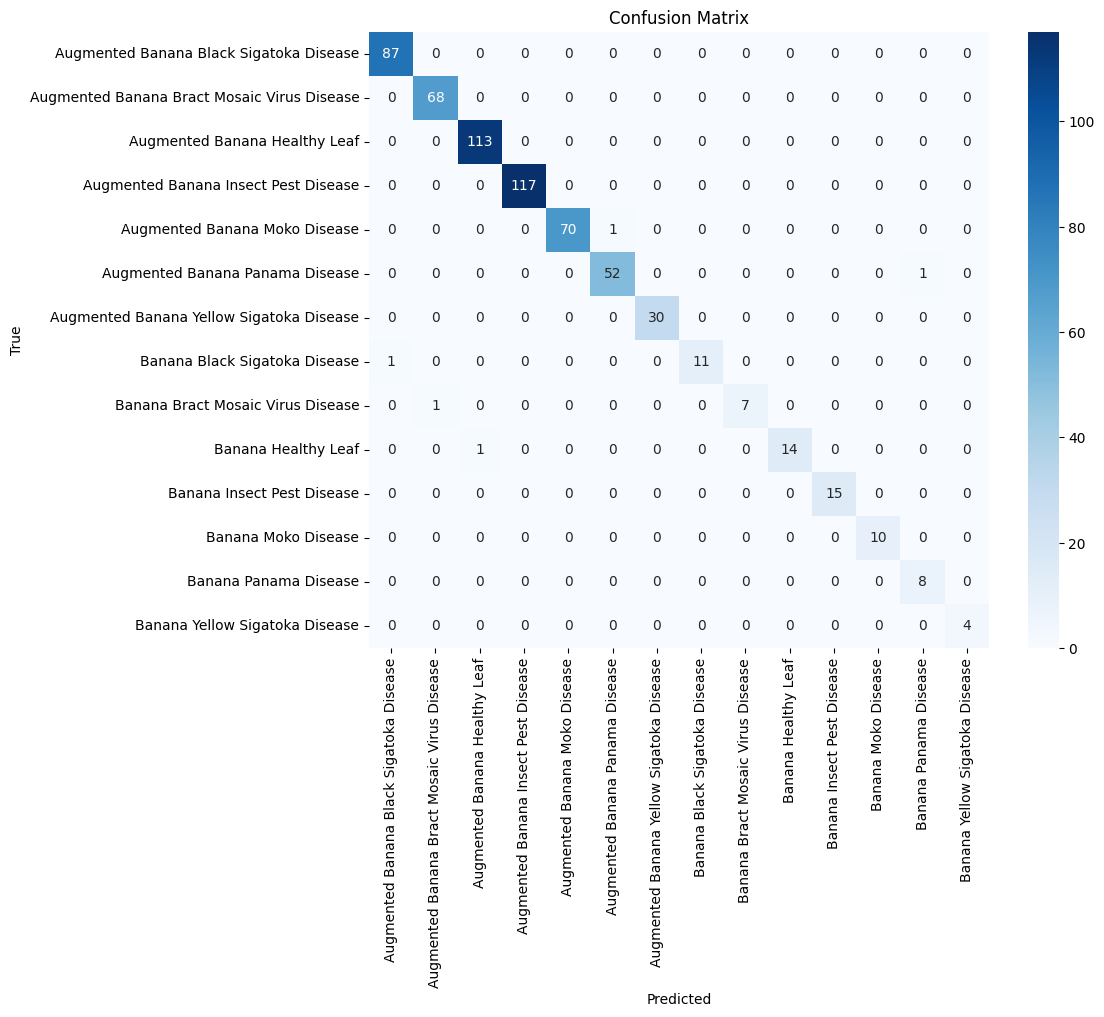

In [111]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Dataset paths and parameters
dataset_path = "C:/Users/narth/Downloads/Banana Disease Recognition Dataset"  
batch_size = 32
img_size = (299, 299)  

# Load datasets
train_ds = image_dataset_from_directory(
    dataset_path + "/train",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'
)
val_ds = image_dataset_from_directory(
    dataset_path + "/val",
    shuffle=False,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Preprocessing
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build InceptionV3 Model
base_model = InceptionV3(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model_inception = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

model_inception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_inception.summary()

# Train model
epochs = 10
history = model_inception.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model_inception.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                        loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine = model_inception.fit(train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=history.epoch[-1])

# Prepare data for evaluation
test_images = []
test_labels = []

for images, labels in val_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Evaluate and plot metrics
y_pred_probs = model_inception.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [113]:
model_inception.save("bananaplant_inception.keras")

In [ ]:
#RESNET50 MODEL

Found 3125 files belonging to 14 classes.
Found 611 files belonging to 14 classes.
Epoch 1/10
98/98 [==============================] - 89s 870ms/step - loss: 1.1773 - accuracy: 0.6774 - val_loss: 0.2371 - val_accuracy: 0.9034
Epoch 2/10
98/98 [==============================] - 83s 846ms/step - loss: 0.4820 - accuracy: 0.8355 - val_loss: 0.1441 - val_accuracy: 0.9476
Epoch 3/10
98/98 [==============================] - 84s 852ms/step - loss: 0.3435 - accuracy: 0.8854 - val_loss: 0.0852 - val_accuracy: 0.9689
Epoch 4/10
98/98 [==============================] - 83s 847ms/step - loss: 0.2617 - accuracy: 0.9078 - val_loss: 0.1079 - val_accuracy: 0.9640
Epoch 5/10
98/98 [==============================] - 84s 854ms/step - loss: 0.2480 - accuracy: 0.9101 - val_loss: 0.0754 - val_accuracy: 0.9738
Epoch 6/10
98/98 [==============================] - 84s 856ms/step - loss: 0.1965 - accuracy: 0.9267 - val_loss: 0.0581 - val_accuracy: 0.9804
Epoch 7/10
98/98 [==============================] - 85s 865

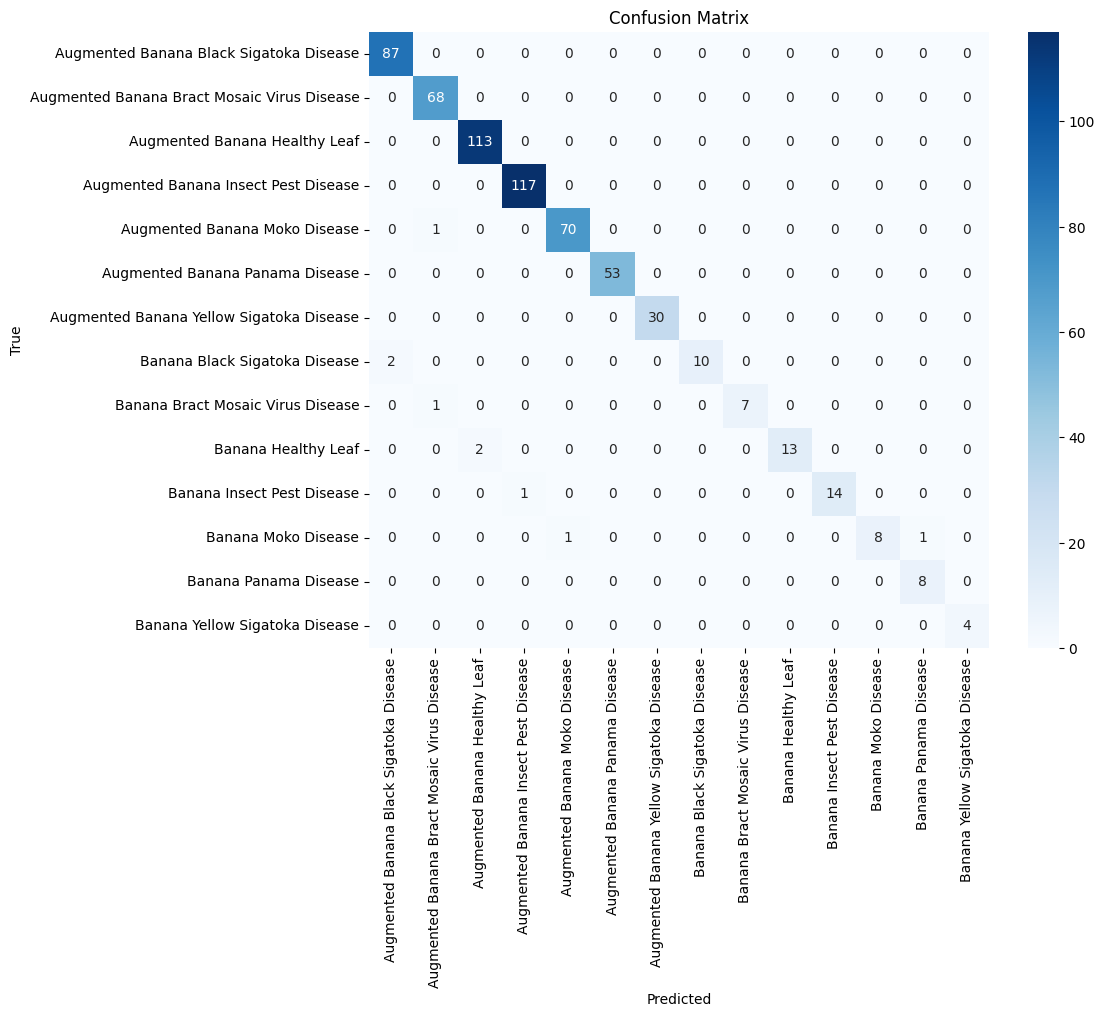

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Dataset paths and parameters
dataset_path = "C:/Users/narth/Downloads/Banana Disease Recognition Dataset"  
batch_size = 32
img_size = (224, 224)  

# Load datasets
train_ds = image_dataset_from_directory(
    dataset_path + "/train",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'
)
val_ds = image_dataset_from_directory(
    dataset_path + "/val",
    shuffle=False,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Preprocessing using ResNet50's preprocess_input
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build ResNet50-based model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_resnet.fit(train_ds, validation_data=val_ds, epochs=10)

# Evaluate model
val_loss, val_acc = model_resnet.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Predict
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model_resnet.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [118]:
model_resnet.save("bananaplant_resnet.keras")

In [ ]:
#EFFICIENTNETB0 MODEL

Found 3125 files belonging to 14 classes.
Found 611 files belonging to 14 classes.
Epoch 1/10
98/98 [==============================] - 44s 399ms/step - loss: 1.3624 - accuracy: 0.6387 - val_loss: 0.4827 - val_accuracy: 0.8674
Epoch 2/10
98/98 [==============================] - 37s 380ms/step - loss: 0.5876 - accuracy: 0.8093 - val_loss: 0.2300 - val_accuracy: 0.9329
Epoch 3/10
98/98 [==============================] - 37s 377ms/step - loss: 0.4375 - accuracy: 0.8512 - val_loss: 0.1387 - val_accuracy: 0.9558
Epoch 4/10
98/98 [==============================] - 36s 365ms/step - loss: 0.3225 - accuracy: 0.8861 - val_loss: 0.1074 - val_accuracy: 0.9656
Epoch 5/10
98/98 [==============================] - 36s 367ms/step - loss: 0.3181 - accuracy: 0.8877 - val_loss: 0.0771 - val_accuracy: 0.9656
Epoch 6/10
98/98 [==============================] - 36s 369ms/step - loss: 0.2640 - accuracy: 0.9053 - val_loss: 0.0744 - val_accuracy: 0.9738
Epoch 7/10
98/98 [==============================] - 38s 386

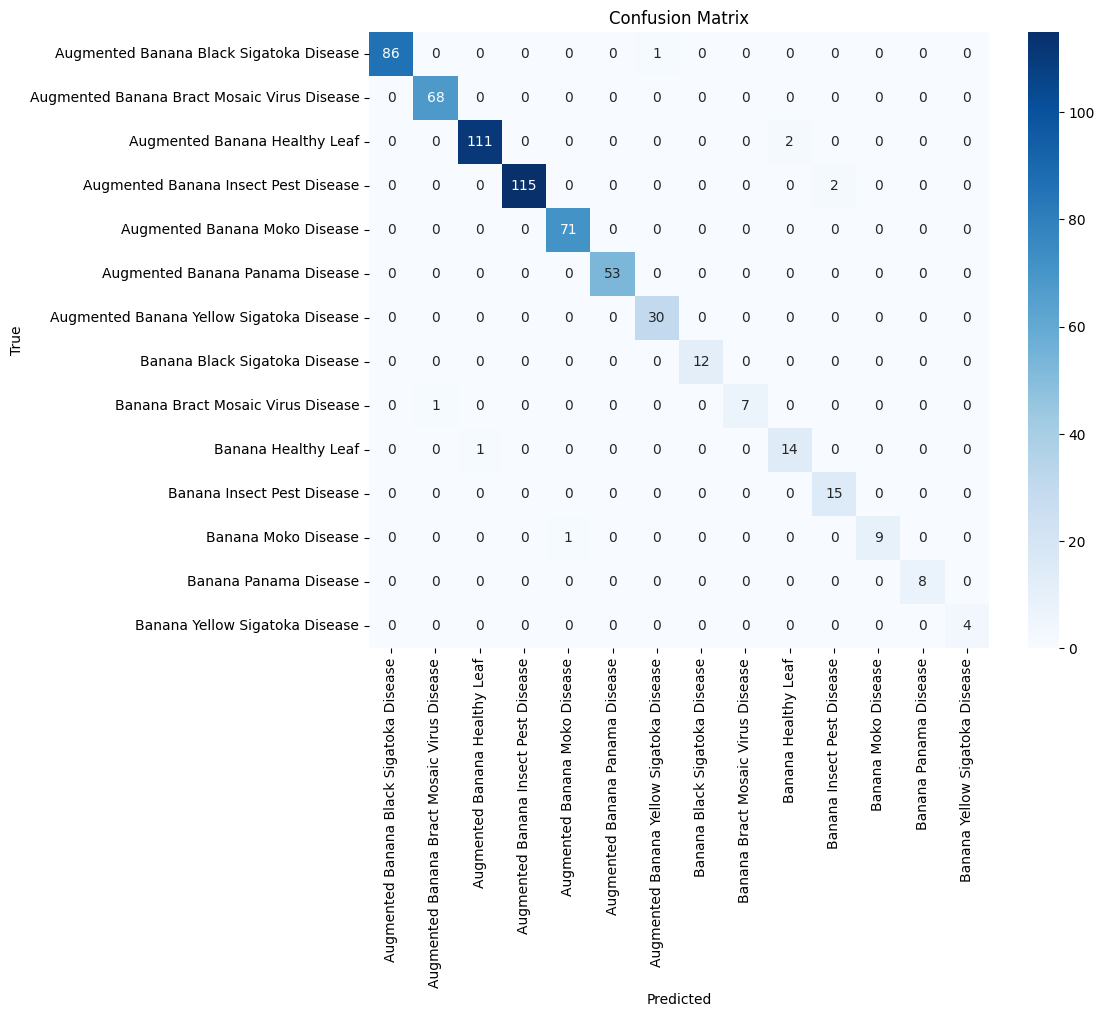

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Dataset paths and parameters
dataset_path = "C:/Users/narth/Downloads/Banana Disease Recognition Dataset"  
batch_size = 32
img_size = (224, 224)  

# Load datasets
train_ds = image_dataset_from_directory(
    dataset_path + "/train",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'
)
val_ds = image_dataset_from_directory(
    dataset_path + "/val",
    shuffle=False,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Preprocessing using EfficientNet's preprocess_input
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build EfficientNetB0-based model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model_eff = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_eff.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_eff.fit(train_ds, validation_data=val_ds, epochs=10)

# Evaluate model
val_loss, val_acc = model_eff.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Predict
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model_eff.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [122]:
model_eff.save("bananaplant_eff.keras")

Found 611 files belonging to 14 classes.

Evaluating Basic CNN...
Found 611 files belonging to 14 classes.
1/1 [==============================] - 0s 96ms/step
Accuracy: 0.7954 | Loss: 5.1475 | Time: 1.95 sec
                                             precision    recall  f1-score   support

    Augmented Banana Black Sigatoka Disease       0.84      0.79      0.82        87
Augmented Banana Bract Mosaic Virus Disease       0.68      0.87      0.76        68
              Augmented Banana Healthy Leaf       0.86      1.00      0.93       113
       Augmented Banana Insect Pest Disease       0.84      0.97      0.90       117
              Augmented Banana Moko Disease       0.85      0.79      0.82        71
            Augmented Banana Panama Disease       0.66      0.91      0.76        53
   Augmented Banana Yellow Sigatoka Disease       0.75      0.90      0.82        30
              Banana Black Sigatoka Disease       0.00      0.00      0.00        12
          Banana Bract Mos

C:\Users\narth\.conda\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\narth\.conda\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\narth\.conda\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 611 files belonging to 14 classes.
1/1 [==============================] - 1s 1s/step
Accuracy: 0.9918 | Loss: 0.0494 | Time: 15.56 sec
                                             precision    recall  f1-score   support

    Augmented Banana Black Sigatoka Disease       0.99      1.00      0.99        87
Augmented Banana Bract Mosaic Virus Disease       0.99      1.00      0.99        68
              Augmented Banana Healthy Leaf       0.99      1.00      1.00       113
       Augmented Banana Insect Pest Disease       1.00      1.00      1.00       117
              Augmented Banana Moko Disease       1.00      0.99      0.99        71
            Augmented Banana Panama Disease       0.98      0.98      0.98        53
   Augmented Banana Yellow Sigatoka Disease       1.00      1.00      1.00        30
              Banana Black Sigatoka Disease       1.00      0.92      0.96        12
          Banana Bract Mosaic Virus Disease       1.00      0.88      0.93         8
        

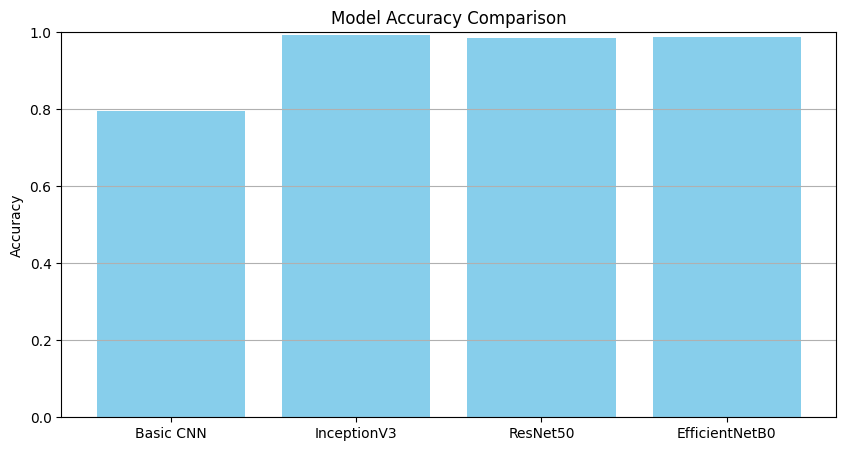

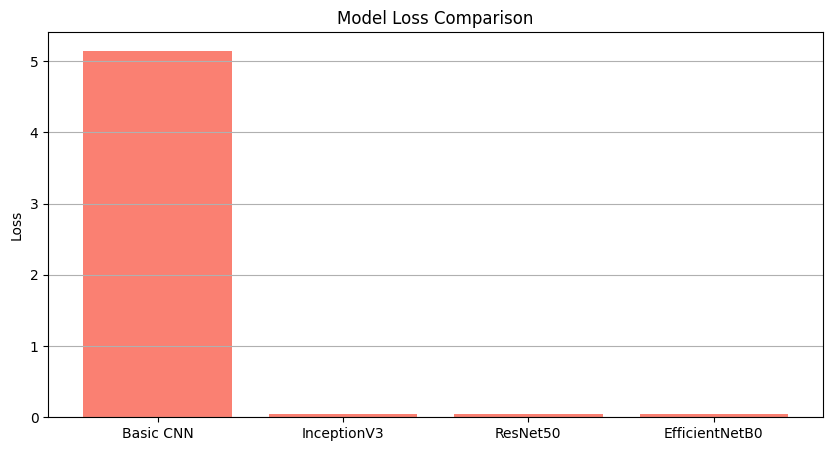

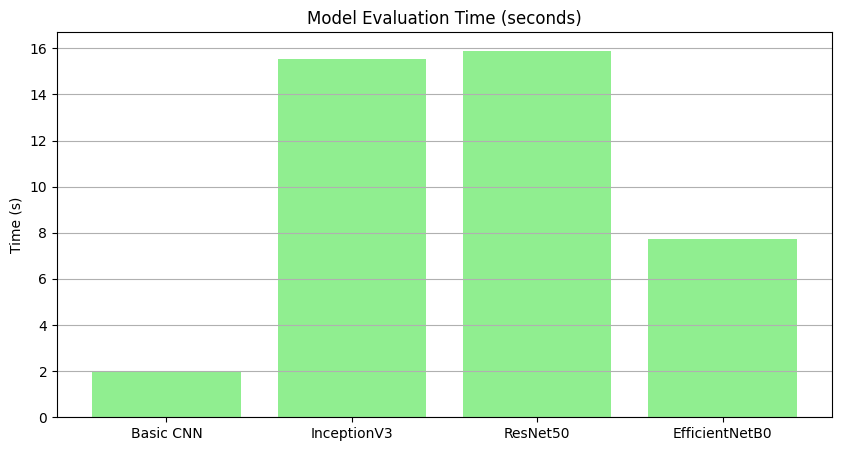


✅ Best Performing Model: **InceptionV3** with Accuracy: 99.18%


In [138]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, accuracy_score


model_paths = {
    "Basic CNN": r"C:\Users\narth\Downloads\Banana Disease Recognition Dataset\training\bananaplant_tf215.keras",
    "InceptionV3": r"C:\Users\narth\Downloads\Banana Disease Recognition Dataset\training\bananaplant_inception.keras",
    "ResNet50": r"C:\Users\narth\Downloads\Banana Disease Recognition Dataset\training\bananaplant_resnet.keras",
    "EfficientNetB0": r"C:\Users\narth\Downloads\Banana Disease Recognition Dataset\training\bananaplant_eff.keras"
}

# Class names
dataset_path = "C:/Users/narth/Downloads/Banana Disease Recognition Dataset"
batch_size = 32

# Get class names from any one dataset load
temp_ds = image_dataset_from_directory(
    dataset_path + "/val",
    shuffle=False,
    batch_size=batch_size,
    image_size=(224, 224),  # temporary
    label_mode='int'
)
class_names = temp_ds.class_names
num_classes = len(class_names)

# Preprocess for different models
def preprocess_model_input(x, model_name):
    if model_name == "InceptionV3":
        from tensorflow.keras.applications.inception_v3 import preprocess_input
    elif model_name == "ResNet50":
        from tensorflow.keras.applications.resnet50 import preprocess_input
    elif model_name == "EfficientNetB0":
        from tensorflow.keras.applications.efficientnet import preprocess_input
    else:
        return x
    return preprocess_input(x)

# Store results
results = {}

# Evaluate each model
for name, path in model_paths.items():
    print(f"\nEvaluating {name}...")
    model = tf.keras.models.load_model(path)

    # Adjust image size based on model
    if name == "InceptionV3":
        current_img_size = (299, 299)
    else:
        current_img_size = (224, 224)

    val_ds_resized = image_dataset_from_directory(
        dataset_path + "/val",
        shuffle=False,
        batch_size=batch_size,
        image_size=current_img_size,
        label_mode='int'
    )

    val_ds_processed = val_ds_resized.map(lambda x, y: (preprocess_model_input(x, name), y)).prefetch(tf.data.AUTOTUNE)

    # Evaluate
    start = time.time()
    loss, acc = model.evaluate(val_ds_processed, verbose=0)
    duration = time.time() - start

    # Predict for detailed metrics
    y_true, y_pred = [], []
    for x_batch, y_batch in val_ds_processed:
        preds = model.predict(x_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    acc_score = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc_score:.4f} | Loss: {loss:.4f} | Time: {duration:.2f} sec")
    print(classification_report(y_true, y_pred, target_names=class_names))

    results[name] = {
        "accuracy": acc_score,
        "loss": loss,
        "time": duration
    }

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), [v["accuracy"] for v in results.values()], color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

# --- Plot Loss Comparison ---
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), [v["loss"] for v in results.values()], color='salmon')
plt.title("Model Loss Comparison")
plt.ylabel("Loss")
plt.grid(True, axis='y')
plt.show()

# --- Plot Time Comparison ---
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), [v["time"] for v in results.values()], color='lightgreen')
plt.title("Model Evaluation Time (seconds)")
plt.ylabel("Time (s)")
plt.grid(True, axis='y')
plt.show()

# --- Best Model Summary ---
best_model = max(results.items(), key=lambda x: x[1]["accuracy"])
print(f"\n✅ Best Performing Model: **{best_model[0]}** with Accuracy: {best_model[1]['accuracy']*100:.2f}%")


In [ ]:
#testing

1/1 [==============================] - 0s 88ms/step


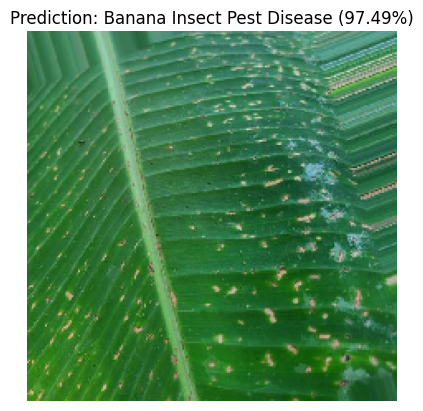

Predicted Class: Banana Insect Pest Disease
Confidence: 97.49%


In [144]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input  # or resnet50 or inception_v3
import os

# Load your saved model 
model = tf.keras.models.load_model(r"C:\Users\narth\Downloads\Banana Disease Recognition Dataset\training\bananaplant_tf215.keras")  # or use the in-memory 'model' if still running

# Class names 
class_names = ['Banana Black Sigatoka Disease',
 'Banana Bract Mosaic Virus Disease',
 'Banana Healthy Leaf',
 'Banana Insect Pest Disease',
 'Banana Moko Disease',
 'Banana Panama Disease',
 'Banana Yellow Sigatoka Disease'] 

# Function to predict a single image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # or (299, 299) for InceptionV3
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    # Plot image with predicted label
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence*100:.2f}%")


predict_image(r"C:\Users\narth\Downloads\Banana Disease Recognition Dataset\Banana Dataset Cleaned\Banana Insect Pest Disease\Augmented Banana Insect Pest Disease (62).jpg")

In [ ]:
#inceptionv3 prediction

In [160]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import tensorflow as tf

# Load model
model = tf.keras.models.load_model(r"C:\Users\narth\Downloads\Banana Disease Recognition Dataset\training\bananaplant_inception.keras")

# Load and preprocess image
img_path = r"C:\Users\narth\Downloads\Banana Disease Recognition Dataset\Banana Dataset Cleaned\Banana Yellow Sigatoka Disease\Augmented Banana Yellow Sigatoka Disease (32).jpg"
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # (1, 299, 299, 3)
img_array = preprocess_input(img_array)

# Predict
preds = model.predict(img_array)
pred_class = np.argmax(preds)
class_names = ['Banana Black Sigatoka Disease',
 'Banana Bract Mosaic Virus Disease',
 'Banana Healthy Leaf',
 'Banana Insect Pest Disease',
 'Banana Moko Disease',
 'Banana Panama Disease',
 'Banana Yellow Sigatoka Disease']  
print("Predicted class:", class_names[pred_class])


1/1 [==============================] - 1s 978ms/step
Predicted class: Banana Yellow Sigatoka Disease
